In [1]:
%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
import pandas as pd
import numpy as np
import os
import sys
import datetime

root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)
    
load_dotenv()

True

In [2]:
# load datasets
from utils.utils import date_range, preprocess_c

df_train = pd.concat([
    pd.read_csv(f'../datasets/d{d.strftime("%Y-%m-%d")}.csv') for d in date_range(
        datetime.date(2019, 11, 1), 
        datetime.date(2020, 2, 1),
        datetime.timedelta(days=1),
    )
])
df_val = pd.concat([
    pd.read_csv(f'../datasets/d{d.strftime("%Y-%m-%d")}.csv') for d in date_range(
        datetime.date(2020, 2, 1), 
        datetime.date(2020, 2, 15),
        datetime.timedelta(days=1),
    )
])

X1_train, X2_train, y_train = preprocess_c(df_train)
X1_val, X2_val, y_val = preprocess_c(df_val)

X1_train.shape, X2_train.shape, y_train.shape, X1_val.shape, X2_val.shape, y_val.shape

((1598125, 1, 4),
 (1598125, 7, 4),
 (1598125, 4),
 (263845, 1, 4),
 (263845, 7, 4),
 (263845, 4))

In [3]:
# model structure
from keras.models import Model, clone_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

prev_days = int(os.getenv('PREV_DAYS'))

visible1 = Input(shape=(1, 4))
branch1 = Dense(32, activation='sigmoid')(visible1)
branch1 = Dense(64, activation='sigmoid')(branch1)
branch1 = Flatten()(branch1)

visible2 = Input(shape=(prev_days, 4))
cnn2 = Conv1D(filters=32, kernel_size=3, activation='sigmoid')(visible2)
cnn2 = MaxPooling1D(pool_size=2)(cnn2)
cnn2 = Flatten()(cnn2)

merge = concatenate([branch1, cnn2])
dense = Dense(8, activation='relu')(merge)
output = Dense(1, activation=LeakyReLU(alpha=0.01))(dense)
model = Model(inputs=[visible1, visible2], outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 4)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 7, 4)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 1, 32)        160         ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 5, 32)        416         ['input_2[0][0]']                
                                                                                              

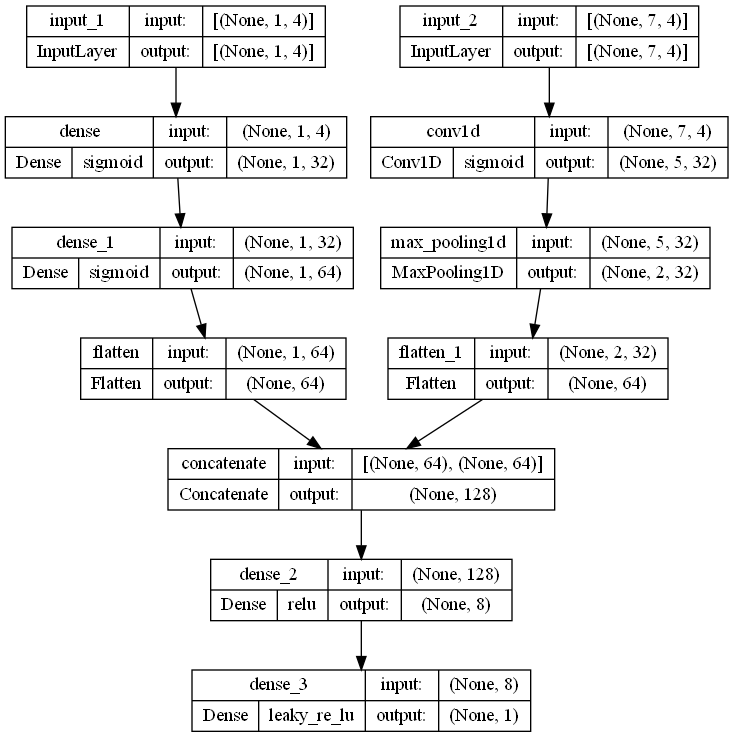

In [4]:
# plot model
from keras.utils import plot_model

plot_model(model,to_file='../.data/model_c.png', show_layer_activations=True, show_shapes=True, show_layer_names=True)

In [5]:
# train view
model_view = clone_model(model)
cp_view = ModelCheckpoint('../model/c-view.keras', save_best_only=True)
model_view.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model_view.fit([X1_train, X2_train], y_train[:, 0], validation_data=([X1_val, X2_val], y_val[:, 0]), epochs=10, callbacks=[cp_view])

Epoch 1/10
49942/49942 [==============================] - 84s 2ms/step - loss: 6.3984e-06 - root_mean_squared_error: 0.0025 - val_loss: 8.4363e-06 - val_root_mean_squared_error: 0.0029
Epoch 2/10
49942/49942 [==============================] - 87s 2ms/step - loss: 4.3922e-06 - root_mean_squared_error: 0.0021 - val_loss: 8.0842e-06 - val_root_mean_squared_error: 0.0028
Epoch 3/10
49942/49942 [==============================] - 90s 2ms/step - loss: 3.7579e-06 - root_mean_squared_error: 0.0019 - val_loss: 9.0038e-06 - val_root_mean_squared_error: 0.0030
Epoch 4/10
49942/49942 [==============================] - 90s 2ms/step - loss: 3.1556e-06 - root_mean_squared_error: 0.0018 - val_loss: 7.5939e-06 - val_root_mean_squared_error: 0.0028
Epoch 5/10
49942/49942 [==============================] - 90s 2ms/step - loss: 2.7441e-06 - root_mean_squared_error: 0.0017 - val_loss: 7.1395e-06 - val_root_mean_squared_error: 0.0027
Epoch 6/10
49942/49942 [==============================] - 89s 2ms/step - lo

In [6]:
# train cart
model_cart = clone_model(model)
cp_cart = ModelCheckpoint('../model/c-cart.keras', save_best_only=True)
model_cart.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model_cart.fit([X1_train, X2_train], y_train[:, 1], validation_data=([X1_val, X2_val], y_val[:, 1]), epochs=10, callbacks=[cp_cart])

Epoch 1/10
49942/49942 [==============================] - 94s 2ms/step - loss: 1.8203e-05 - root_mean_squared_error: 0.0043 - val_loss: 1.9795e-05 - val_root_mean_squared_error: 0.0044
Epoch 2/10
49942/49942 [==============================] - 86s 2ms/step - loss: 1.5117e-05 - root_mean_squared_error: 0.0039 - val_loss: 2.1033e-05 - val_root_mean_squared_error: 0.0046
Epoch 3/10
49942/49942 [==============================] - 74s 1ms/step - loss: 1.4534e-05 - root_mean_squared_error: 0.0038 - val_loss: 1.4858e-05 - val_root_mean_squared_error: 0.0039
Epoch 4/10
49942/49942 [==============================] - 74s 1ms/step - loss: 1.3139e-05 - root_mean_squared_error: 0.0036 - val_loss: 1.2912e-05 - val_root_mean_squared_error: 0.0036
Epoch 5/10
49942/49942 [==============================] - 74s 1ms/step - loss: 1.2312e-05 - root_mean_squared_error: 0.0035 - val_loss: 1.1907e-05 - val_root_mean_squared_error: 0.0035
Epoch 6/10
49942/49942 [==============================] - 75s 2ms/step - lo

In [7]:
# train remove_from_cart
model_remove_from_cart = clone_model(model)
cp_remove_from_cart = ModelCheckpoint('../model/c-remove_from_cart.keras', save_best_only=True)
model_remove_from_cart.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model_remove_from_cart.fit([X1_train, X2_train], y_train[:, 2], validation_data=([X1_val, X2_val], y_val[:, 2]), epochs=10, callbacks=[cp_remove_from_cart])

Epoch 1/10
49942/49942 [==============================] - 83s 2ms/step - loss: 1.0875e-04 - root_mean_squared_error: 0.0104 - val_loss: 1.0646e-04 - val_root_mean_squared_error: 0.0103
Epoch 2/10
49942/49942 [==============================] - 79s 2ms/step - loss: 9.5352e-05 - root_mean_squared_error: 0.0098 - val_loss: 9.9285e-05 - val_root_mean_squared_error: 0.0100
Epoch 3/10
49942/49942 [==============================] - 80s 2ms/step - loss: 9.3745e-05 - root_mean_squared_error: 0.0097 - val_loss: 9.9275e-05 - val_root_mean_squared_error: 0.0100
Epoch 4/10
49942/49942 [==============================] - 80s 2ms/step - loss: 9.2114e-05 - root_mean_squared_error: 0.0096 - val_loss: 9.9745e-05 - val_root_mean_squared_error: 0.0100
Epoch 5/10
49942/49942 [==============================] - 87s 2ms/step - loss: 9.1199e-05 - root_mean_squared_error: 0.0095 - val_loss: 1.0800e-04 - val_root_mean_squared_error: 0.0104
Epoch 6/10
49942/49942 [==============================] - 80s 2ms/step - lo

In [8]:
# train purchase
model_purchase = clone_model(model)
cp_purchase = ModelCheckpoint('../model/c-purchase.keras', save_best_only=True)
model_purchase.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model_purchase.fit([X1_train, X2_train], y_train[:, 3], validation_data=([X1_val, X2_val], y_val[:, 3]), epochs=10, callbacks=[cp_purchase])

Epoch 1/10
49942/49942 [==============================] - 90s 2ms/step - loss: 5.5001e-05 - root_mean_squared_error: 0.0074 - val_loss: 2.6820e-05 - val_root_mean_squared_error: 0.0052
Epoch 2/10
49942/49942 [==============================] - 94s 2ms/step - loss: 4.0229e-05 - root_mean_squared_error: 0.0063 - val_loss: 2.9641e-05 - val_root_mean_squared_error: 0.0054
Epoch 3/10
49942/49942 [==============================] - 85s 2ms/step - loss: 3.8937e-05 - root_mean_squared_error: 0.0062 - val_loss: 3.8967e-05 - val_root_mean_squared_error: 0.0062
Epoch 4/10
49942/49942 [==============================] - 87s 2ms/step - loss: 3.8059e-05 - root_mean_squared_error: 0.0062 - val_loss: 2.6947e-05 - val_root_mean_squared_error: 0.0052
Epoch 5/10
49942/49942 [==============================] - 94s 2ms/step - loss: 3.7390e-05 - root_mean_squared_error: 0.0061 - val_loss: 2.6878e-05 - val_root_mean_squared_error: 0.0052
Epoch 6/10
49942/49942 [==============================] - 91s 2ms/step - lo